# Unit 2 - Introduction to Feedback and Control

# Outline
- The advantages/objectives of control
- The feedback equation (sensitivity and complementary sensitivity functions)
- Proportional controller
- Root Locus plots
- Gain and phase margins (Bode plots)
- Nyquist plots
- Loop shaping 



# Notation

![openloop](openloop.png "Open-Loop")

- $P$: plant (system)
- $u$: input (variable can be manipulated)
- $y$: output (variable to be controlled)
- $d$: disturbance (affects value of input)
- $n$: measurement noise (sensor noise) (affects the measurement of a variable)

![feedbackloop](feedbackloop.png "Feedback")

- $K$: controller
- $r$: reference signal (desired output)
- $y_m$: measured output
- $\varepsilon$ (difference between desired output and measured output)


# Why feedback?










- Ability to follow desired signals
- Stability (design)
- Reduction of effects of process noise / load disturbances (noise rejection, compensation)
- Reduction of effects of model uncertainties
- Efficiency (design)

# Let's illustrate these advantages using a simplified model a cruise control system!

![Car](car.png "Car")

source: https://www.istockphoto.com/photos/futuristic-car-isolated


![Car free body diagram](car-free-body-diagram.png "Car free body diagram")

where,
- $F_d$ is the force due to drag
- $F_f$ is the force due to friction
- $F_a$ is the force applied by the wheels

Force due to drag:
$$
\begin{align*}
F_d = k_d v 
\end{align*}
$$
where 
- $k_d$ is drag coefficient,
- $v$ is speed of the car. 

Force due to gravity:
$$
\begin{align*}
F_g = m g 
\end{align*}
$$
where 
- $m$ is mass of car,
- $g$ is acceleration due to gravity. 

Force due to friction:
$$
\begin{align*}
F_f &= k_f v F_n \\
&= k_f v F_g \\
&= k_f v m g \\
\end{align*}
$$
where 
- $F_n$ is normal force,
- $k_f$ is friction coefficient.

# In Class Activity!

Derive transfer function of the simplified car model where $F_a$ is the input and $v$ is the output.

# Putting it all together. 

Sum of forces:
$$
\begin{align*}
\sum F &= ma \\
F_a(t) - F_d(t) - F_f(t) &= ma(t) \\
F_a(t) - k_dv(t) - k_fmgv(t) &= m \frac{\text{d} v(t)}{\text{dt}} \\
F_a(t) - (k_d - k_fmg)v(t) &= m \frac{\text{d} v(t)}{\text{dt}}
\end{align*}
$$
let $k=k_d-k_fmg$, then:
$$
\begin{align*}
F_a(t) - k v(t)= m \frac{\text{d} v(t)}{\text{dt}}
\end{align*}
$$

Take Laplace transform of both sides:
$$
\begin{align*}
F_a(s) - k V(s) = m(sV(s)-v(0))
\end{align*}
$$
Rearrange:
$$
\begin{align*}
V(s) = \frac{1}{ms + k}F(s) - \frac{m}{ms + k}v(0)
\end{align*}
$$
So the transfer function of the car is:
$$
\begin{align*}
G(s) = \frac{1}{ms + k}
\end{align*}
$$





In [1]:
import control as ct
import numpy as np
import enel441_utilities as eu
import math
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
# Very simple model of a car (input = force applied by wheels, output = speed of car)
m = 1000 #kg
k = 500 #Ns/m

s = ct.tf('s')
Car = 1/(m*s+k)

# Controller (for cruise control) For this lecture, I have designed this controller. 
# In the remainder of this course, you will learn how to design this type of controller.
K = 1*(m*s+k)/s


# In Class Activity

Spend some time exploring this model. Make Bode plot, S-plane plot, Unit Step Response.

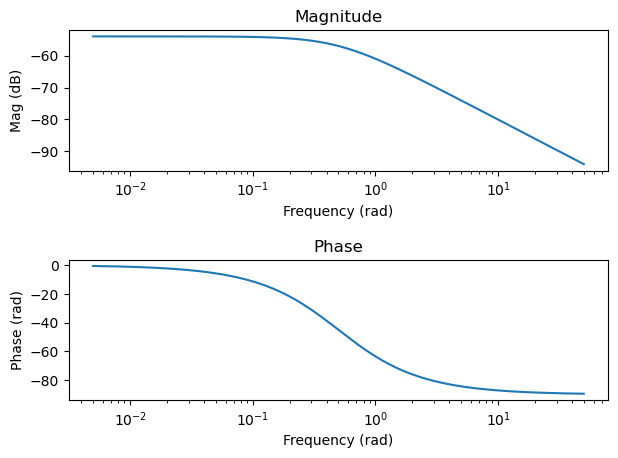

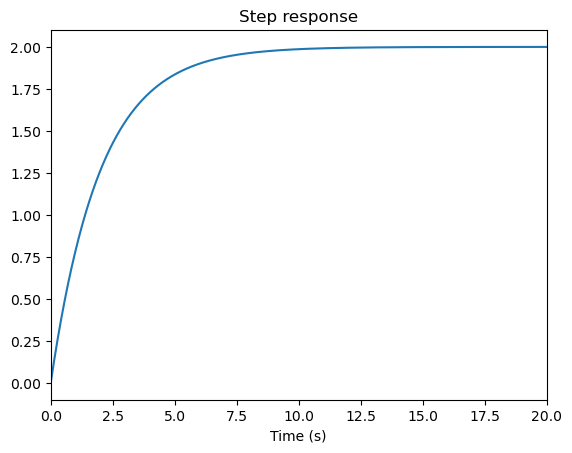

In [3]:
num = np.array([1])
den = np.array([m, k])
den_step = np.array([m, k, 0])

N = 1000
omega = eu.enel441_get_reasonable_freq_range(num,den,N)
G_jw = eu.enel441_fourier_transform(num,den,omega)
eu.enel441_bode(G_jw,omega)


t = np.linspace(0,20,N)
eu.enel441_step_response(num, den_step, t)

plt.show()

# Back to: Advantages of Control

- Ability to follow desired signals (responsiveness of system)
- Stability (design)
- Reduction of effects of process noise / load disturbances (noise rejection, compensation)
- Reduction of effects of model uncertainties
- Efficiency (design)

# Advantage 1 - Increase Responsiveness of System!

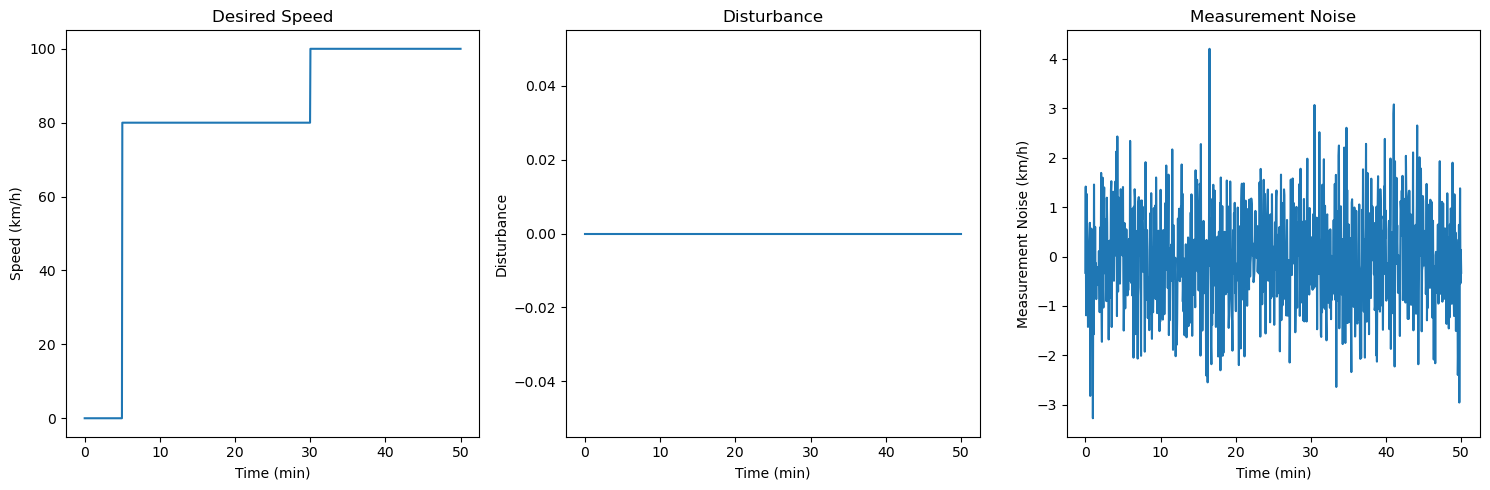

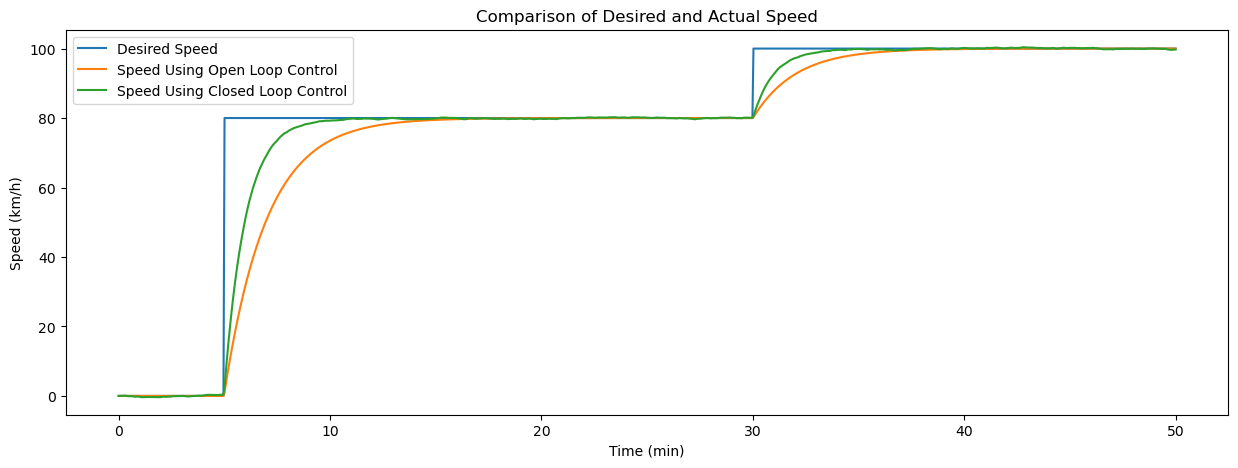

In [4]:
def sim_closed_loop(P,K,t,r,d,n):
    L = K*P
    S = 1/(1+L)
    T = L/(1+L)   

    y_r = ct.forced_response(T,t,r) 
    y_n = ct.forced_response(T,t,n) 
    y_d = ct.forced_response(P*S,t,d) 

    y = y_r.y + y_d.y + y_n.y

    u_r = ct.forced_response(K*S,t,r) 
    u_d = ct.forced_response(S,t,d) 
    u_n = ct.forced_response(K*S,t,d) 

    u = u_r.y + u_d.y - u_n.y

    return np.squeeze(y), np.squeeze(u)


def sim_open_loop(P,t,u,d):    
    y_r = ct.forced_response(P,t,u) 
    y_d = ct.forced_response(P,t,d) 
    y = np.squeeze(y_r.y) + np.squeeze(y_d.y)  
    return y


def make_open_and_closed_loop_plots(t,r,d,n,y2,y1):
    fig,ax = plt.subplots(1,3, figsize=(15,5) )
    ax[0].plot(t,r)
    ax[0].set_xlabel('Time (min)')
    ax[0].set_ylabel('Speed (km/h)')
    ax[0].set_title('Desired Speed')
    ax[1].plot(t,d)
    ax[1].set_xlabel('Time (min)')
    ax[1].set_ylabel('Disturbance')
    ax[1].set_title('Disturbance')   
    ax[2].plot(t,n)    
    ax[2].set_xlabel('Time (min)')
    ax[2].set_ylabel('Measurement Noise (km/h)')
    ax[2].set_title('Measurement Noise')
        
    fig.tight_layout()
    
    fig,ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(t,r, label='Desired Speed')
    ax.plot(t,y1, label='Speed Using Open Loop Control')   
    ax.plot(t,y2, label='Speed Using Closed Loop Control') 
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Speed (km/h)')
    ax.set_title('Comparison of Desired and Actual Speed')
    plt.legend()


# Reference, disturbance and measurement noise signals
t = np.linspace(0, 50, N)
r = [0 if ti <= 5 else
     80 if ti <= 30 else
     100 for ti in t]
r = np.array(r) 
d = np.zeros(N)
n = np.random.randn(N)

# simulate closed-loop and open-loop models for selected reference, disturbance and measurement noise signals
y_closed_loop, _ = sim_closed_loop(Car,K,t,r,d,n)
y_open_loop = sim_open_loop(Car,t,r*k,d)  # need to multiply input by k to "calibrate" input force. Why? (Check v(\infty) when r is a unit step).

# plot results
make_open_and_closed_loop_plots(t,r,d,n,y_closed_loop,y_open_loop)

# What is happening here? How are we able to speed up the response?

In open loop control we have pre-calculated what the input should be to achieve our desired speed. In this example it is just the desired speed.

So how is the controller able to speed up the response? Can think about it in (at least) two ways:

1. From the point of view of the input to the car: 
    - The controller is actively manipulating the input. 
    - This is an intuitive way to think about it, especially in the case of controlling the speed of a car. Instead of just setting the gas pedal (i.e. the force) to the level required to go the desired speed and keeping it there until you reach your desired speed, initially you might press harder on the gas to accelerate faster and then when you approach the desired speed, you reduce the pressure on the gas pedal. 
2. From the point of view of the poles of the system:
    - In open loop the transfer function from input (force of engine) to output is just the dynamics of the car.
    - In closed loop the transfer function from input to output has been changed, we have inserted a feedback loop and a controller.
    - The closed-loop transfer function will have different poles than the open-loop transfer function. The poles of the closed-loop system must be such that the step-response rise-time is less.

# Let's look at both points of view.


# In Class Activity!

For the above simulation, let's compare the input of our open-loop controller and the closed-loop controller. 
First we need to find the expression for the input to the plant. In the closed-loop system shown below, obtain an expression for the transfer function from $r(t)$ to $u(t)$

![feedbackloop](feedbackloop.png "Feedback")

For this exercise, assume that $n$ and $d$ are zero.


The transfer function from $r$ to $u$ is:
$$
\begin{align*}
\frac{U(s)}{R(s)} = \frac{K(s)}{1 + K(s)P(s)}
\end{align*}
$$


# In Class Activity!

Write some Python code to plot the time response of $u$ given $r$. The code from previous cells has been copied below for your convenience.

In [5]:
def plot_input_to_plant(K,P,r,t):
     # Add code here
     #X = ??
     
     u_r = ct.forced_response(X,t,r) 

     fig, ax = plt.subplots(1)
     ax.plot(t, np.squeeze(u_r.y),label='Input to Car In Closed-Loop')
     ax.set_title('Response of Plant input')
     ax.set_xlabel('Time (s)')
     
     return fig, ax

fig,ax = plot_input_to_plant(K,Car,r,t)
ax.plot(t,r*k, label='Input to Car in Open-Loop')
ax.legend()

NameError: name 'X' is not defined

What is the main difference? How is the controller able to achieve the increase in response time of the car?

Point of view #2: look at poles of open- and closed-loop systems.

In a closed loop setup, what is the transfer function from desired speed (reference signal) to output?

# In Class Activity!

Find the transfer function from $r$ to $y$ for a closed loop system. Again, assume that $n$ and $d$ are zero. Note the transfer functions for the car and controller are:
$$
\begin{align*}
P(s) &= \frac{1}{ms + k} \\
K(s) &= \frac{ms + k}{s}
\end{align*}
$$
Determine which system has a faster rise time.

The transfer function from $r$ to $y$ is:
$$
\begin{align*}
\frac{Y(s)}{R(s)} &= \frac{K(s)P(s)}{1 + K(s)P(s)} \\
&= \frac{1}{s+1}
\end{align*}
$$

The rise time for a first order system $\frac{a}{s+a}$ is $T_r = 2.2/a$. The bigger, $a$, the faster the rise time. 

In conclusion, 
- The open-loop transfer function has a pole at $-k/m = -500/1000 = -0.5$. $T_r = 2.2/0.5 = 4.4$.
- The closed-loop system has a pole at $-1$. $T_r = 2.2/1 = 2.2$.
- The closed-loop system has faster rise time. 



So far we have seen that the controller sped up the dynamics of the system. 

Let's continue to illustrate the other advantages of using controllers.

# Advantage 2 - Disturbance Rejection

# Effect of disturbance (open-loop vs closed-loop)

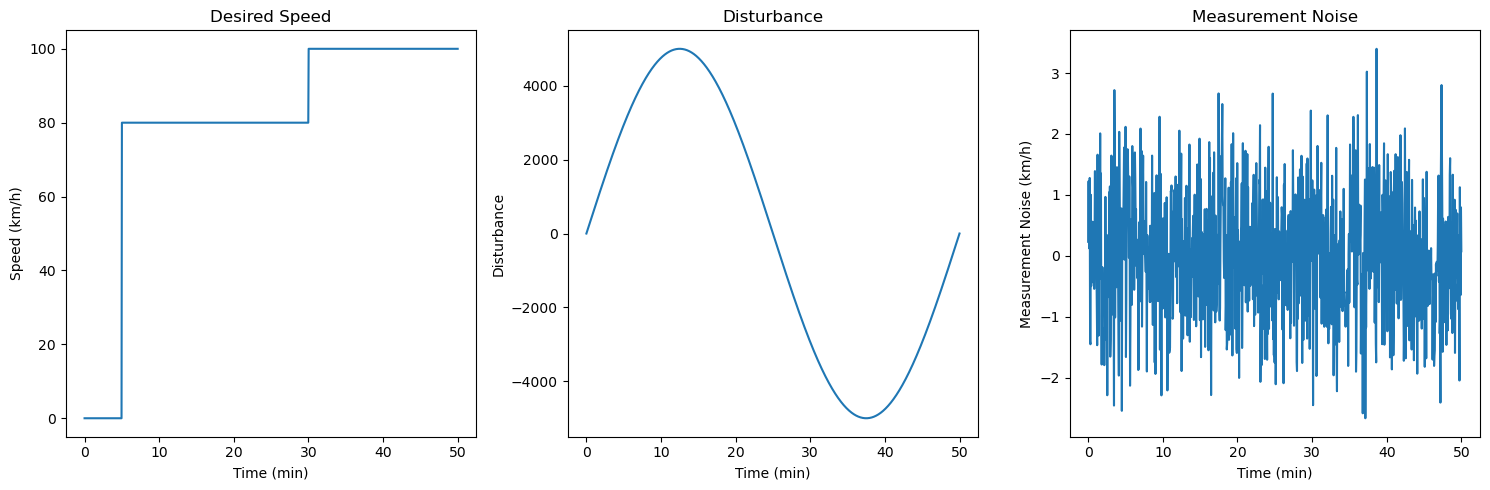

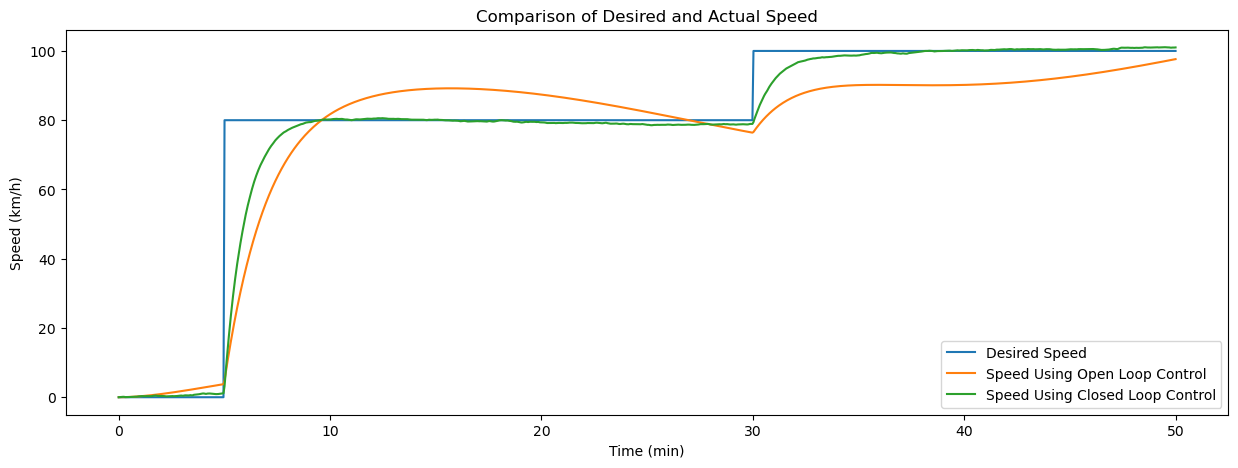

In [6]:
t = np.linspace(0, 50, N)
r = [0 if ti <= 5 else
     80 if ti <= 30 else
     100 for ti in t]
r = np.array(r) 
n = np.random.randn(N)

d_hill = 10*np.sin(t/100*np.pi*4)*k
y_closed_loop, u_closed_loop = eu.enel441_sim_closed_loop(Car,K,t,r,d_hill,n)
y_open_loop = eu.enel441_sim_open_loop(Car,t,r*k,d_hill)

eu.enel441_make_open_and_closed_loop_plots(t,r,d_hill,n,y_closed_loop,y_open_loop)


# Again - What is happening here? 

How is the controller able to maintain the correct speed, even when going up hill and down hill?

Again - Let's look at what the controller is prescribing as the input to the car.

# In Class Activity!

Derive the expression for the input to the plant based on the feedback diagram below. This time express the input in terms of $r$ and $d$. Assume that $n$ is zero. 

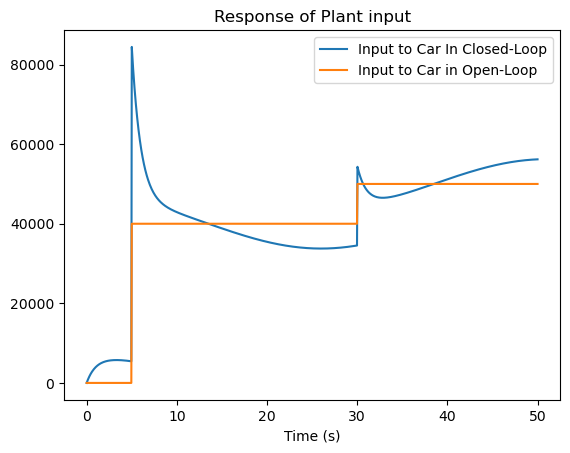

In [7]:
def plot_input_to_plant(K,P,r,d,t):
    # Add code here
    L = K*P
    S = 1/(1+L)
    T = L/(1+L)   

    X_r = K*S
    X_d = S
    
    u_r = ct.forced_response(X_r,t,r) 
    u_d = ct.forced_response(X_d,t,d) 

    u = u_r.y + u_d.y

    fig, ax = plt.subplots(1)
    ax.plot(t, np.squeeze(u),label='Input to Car In Closed-Loop')
    ax.set_title('Response of Plant input')
    ax.set_xlabel('Time (s)')
     
    return fig, ax

d_hill = 100*np.sin(t/100*np.pi*4)*k
fig,ax = plot_input_to_plant(K,Car,r,d_hill,t)
ax.plot(t,r*k, label='Input to Car in Open-Loop')
ax.legend()

# Advantage 3 - Reducing the effects of model uncertainty

Suppose that the dynamics of the car change, or are not exactly represented by the model. 

# Effect of uncertainty in the model (open-loop vs closed-loop)

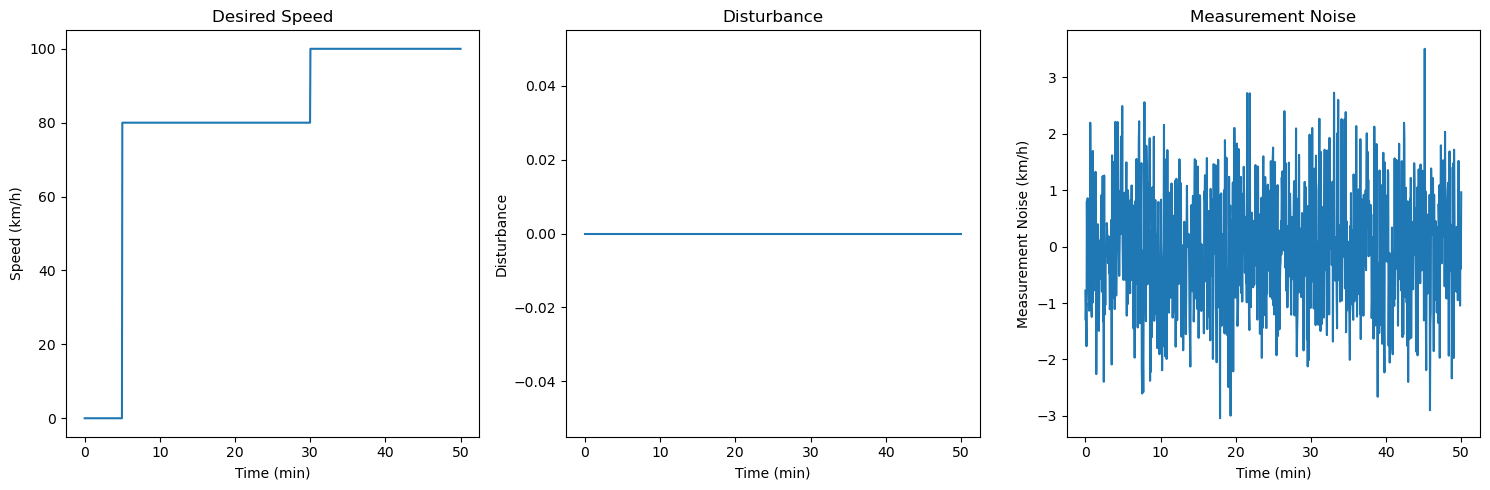

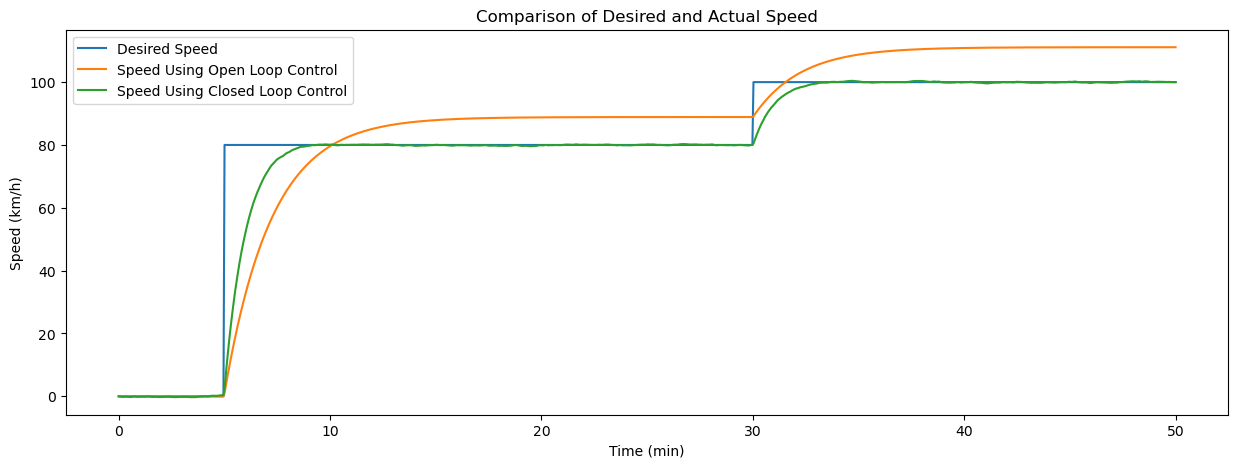

In [8]:
k = 500
k_new = 450

Car_changed = 1/(m*s+k_new)


t = np.linspace(0, 50, N)
r = [0 if ti <= 5 else
     80 if ti <= 30 else
     100 for ti in t]
r = np.array(r) 
d = np.zeros(N)
n = np.random.randn(N)


y_closed_loop, u_closed_loop = eu.enel441_sim_closed_loop(Car_changed,K,t,r,d,n)
y_open_loop = eu.enel441_sim_open_loop(Car_changed,t,r*k,d)
    
eu.enel441_make_open_and_closed_loop_plots(t,r,d,n,y_closed_loop,y_open_loop)

# Summary so far

Feedback can help with:
- Increasing responsiveness of system
- Reduction of effects of process noise / load disturbances (noise rejection, compensation)
- Reduction of effects of model uncertainties

# The Feedback Equation!

![feedbackloop](feedbackloop.png "Feedback")

$$
\begin{align}
y(s) &= P(s) \Big( u(s) + d(s) \Big) \\
&= P(s)K(s) \Big( r(s) - y_m(s) \Big ) + P(s)d(s) \\
&= P(s)K(s) r(s) - P(s)K(s) y_m(s) + P(s)d(s) \\
&= P(s)K(s)r(s) - P(s)K(s)\Big(y(s) + n(s)\Big) + P(s)d(s) \\
&= P(s)K(s)r(s) - P(s)K(s)y(s)  - P(s)K(s) n(s)+ P(s)d(s) \\
&= \underbrace{\frac{P(s)K(s)}{1+P(s)K(s)}}_{\substack{\text{closed-loop} \\ \text{transfer function}}} r(s) - \frac{P(s)K(s)}{1+P(s)K(s)}n(s) + \frac{P(s)}{1+P(s)K(s)}d(s)
\end{align}
$$

Loop transfer function:

$$L(s) = P(s)K(s)$$

Sensitivity Function:

$$S(s) = \frac{1}{1+P(s)K(s)} = \frac{1}{1 + L}$$ 

Complementary Sensitivity Function:

$$T(s) = \frac{P(s)K(s)}{1+P(s)K(s)} = \frac{L}{1+L}$$ 

Express feedback equation in terms of $T$ and $S$:

$$y(s) = T(s)r(s) - T(s)n(s) + S(s)P(s)d(s)$$


# Tracking Error

Interestingly, we can compare the actual output, $y$, with the desired output, $r$! 
- This is called the tracking error. 
- Normally, we want the tracking error to be small. 

In equations:

$$
\begin{align}
\varepsilon(s) &= r(s) - y(s) \\
&= r(s) -  T(s)r(s) - T(s)n(s) - S(s)P(s)d(s) \\
&= S(s)r(s) + T(s)n(s) - S(s)P(s)d(s)
\end{align}
$$

# Key insight (this is important):
- $S(s)$ determines the error due to not tracking $r$ 
- $S(s)$ determines the error due to process disturbances $d$
- $T(s)$ determines the error due to measurement noise $n$

# We want both $S(s)$ and $T(s)$ to be small!!
# However $S(s) + T(s) = 1$. 

(so we can't make both small at the same time...)


# In Class Activity!

Prove that $S(s) + T(s) = 1$.

# So far
- have illustrated the advantages of control (increase performance, disturbance rejection, increased robustness)
- Studied feedback equation and looked at the dynamics of the tracking error (sensitivity and complementary sensitivity functions)

# Next Step:
- let's look at some ideas for choosing the controller $K$. 
- will look at 2 ideas based directly on our understanding of the feedback equation. 
- objective is to develop an understanding how controllers can affect the tracking error.

# Next Section: Focus on Increasing Performance 

First attempt: Proportional Control

# Let's design $K$! (Idea 1)

There are several possibilities to obtain this desired behaviour:

choose $K$ as a (large) constant.

$$\varepsilon(s) = \frac{1}{1+K(s)P(s)}r(s) - \frac{K(s)P(s)}{1+K(s)P(s)}n(s) - \frac{P(s)}{1+K(s)P(s)}d(s)$$



# In Class Activity!

Use code below to try different values of $K$

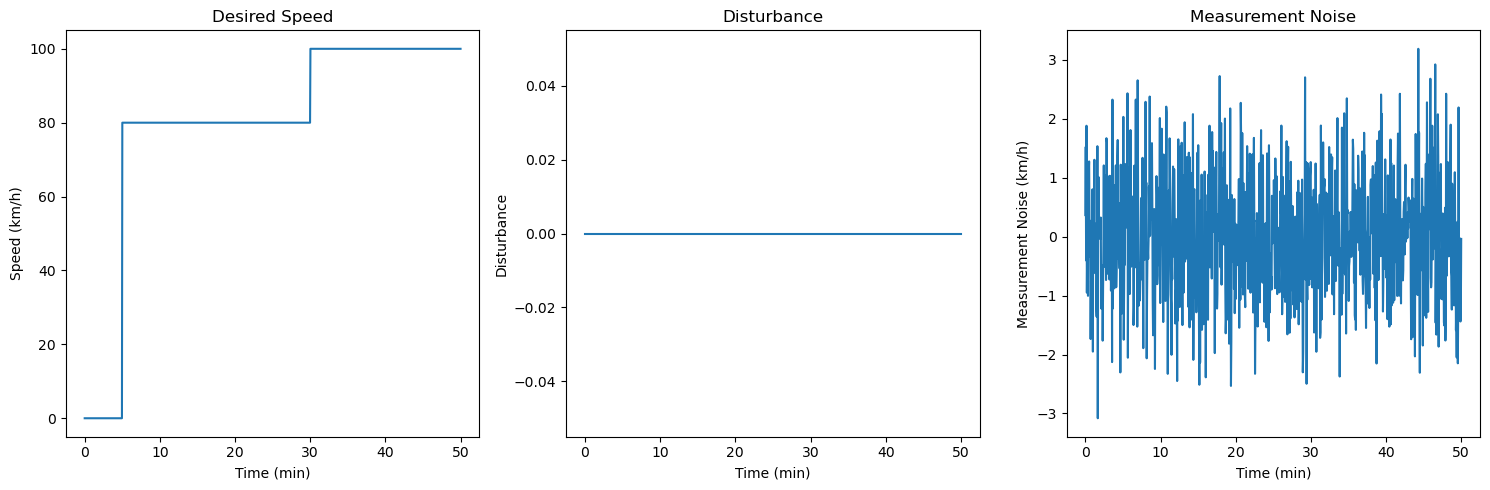

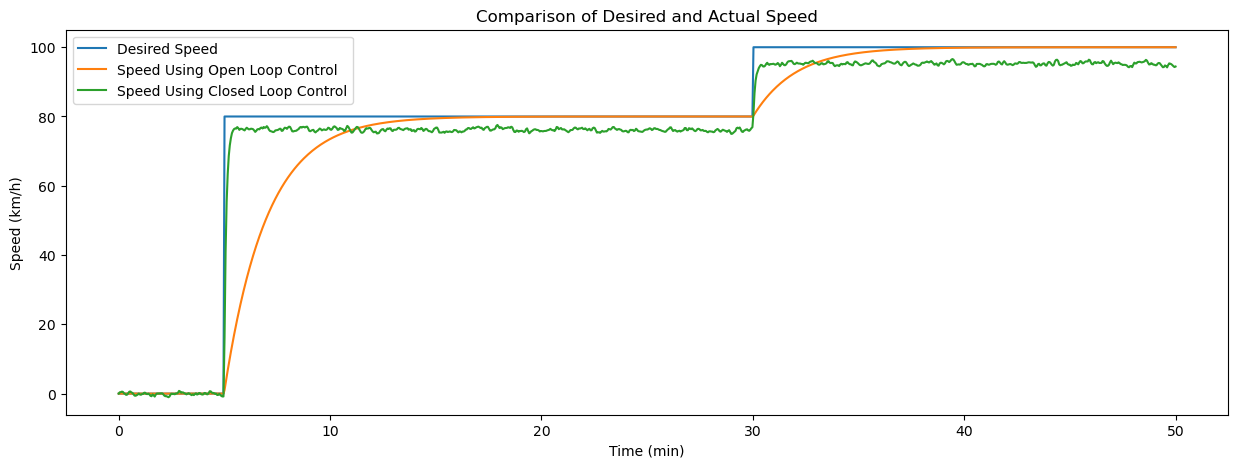

In [9]:

# Reference, disturbance and measurement noise signals
t = np.linspace(0, 50, N)
r = [0 if ti <= 5 else
     80 if ti <= 30 else
     100 for ti in t]
r = np.array(r)
d = np.zeros(N)
n = np.random.randn(N)

# try different controllers
K = 10000

y_closed_loop, u_closed_loop = eu.enel441_sim_closed_loop(Car,K,t,r,d,n)
y_open_loop = eu.enel441_sim_open_loop(Car,t,r*k,d)
    
eu.enel441_make_open_and_closed_loop_plots(t,r,d,n,y_closed_loop,y_open_loop)

# What do you notice? 

Can we explain this behavior? 

Some observations:
- for small $K$, the steady state error is very big. Why? 

Let's obtain an expression for the steady state error to find out why. The steady state error is $\varepsilon(\infty)$ with $r(t)$ a step function $v_{des} 1(t)$, and assume $n$ and $d$ are zero. Then:
$$
\begin{align*}
\mathcal{E}(s) &= S(s)R(s) \\
&= \frac{1}{1 + P(s)K} \frac{v_{des}}{s} \\
&= \frac{v_{des}(ms + k)}{s(ms + k + K)} 
\end{align*}
$$
Use the Laplace transform property to calculate $\varepsilon(\infty)$:
$$
\begin{align*}
\varepsilon(\infty) &= \lim_{s \to 0} s \frac{v_{des}(ms + k)}{s(ms + k + K)} 
&= \frac{v_{des} k}{k + K}
\end{align*}
$$
So we see for small $K$, we have a large steady state error, whereas for large $K$ we have a small steady state error, just as we observed in the simulations!

# What behaviors are possible by changing K? 

And what behaviors are not possible? 

Idea: plot possible poles and zeros of closed-loop transfer function in the s-plane.

This is called a Root Locus Plot. 

# In Class Activity

We have seen that the transfer function from $r$ to $y$ is equal to the complementary sensitivity function $T(s)$. Now express the plant (i.e. the car) as $P(s) = \frac{B(s)}{A(s)}$. In addition, let $K$ be a constant (i.e. not a function of $s$). Derive an expression for $Y(s)$ assuming that $d$ and $n$ are zero. 

From feedback equation, the transfer function from $r$ to $y$ is just $T$, so we have:
$$
\begin{align*}
Y(s) &= T(s)R(s) \\
&= \frac{P(s)K}{1 + P(s)K}
\end{align*}
$$

Express $P(s) = \frac{B(s)}{A(s)}$:
$$
\begin{align*}
Y(s) &= \frac{\frac{B(s)}{A(s)}K}{1 + \frac{B(s)}{A(s)}K} \\
&= \frac{KB(s)}{A(s) +B(s)K}
\end{align*}
$$

This is an expression of the closed-loop transfer function as a function of $K$ (where $K$ is a constant). What do we observe?
- poles of closed loop system depend on $K$
- this expression defines what behaviors we can obtain using a proportional controller (i.e. constant $K$)

We want to visualize the possible behaviors somehow! (and know what the limitations are of using a proportional controller)



# 2 Ideas:
1. Look at Bode Plot of Sensitivity and Complementary Sensitivity for different values of $K$
2. Plot poles and zeros for a whole range of $K$ in the s-plane. This is called a Root Locus plot.

# In Class Activity

- Make Bode plots for different values of $K$. 
- Remember that our objective was to make $S$ small. (Why?)

[ 1000. 10500.]
[1000  500]


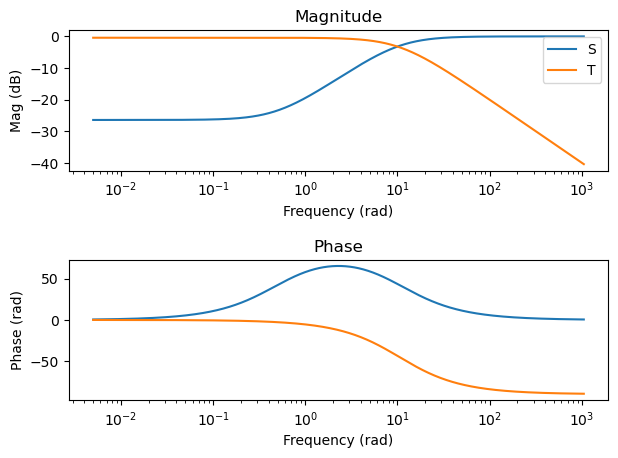

In [16]:

import importlib
importlib.reload(eu)

def get_closed_loop_denominator(num, den, K):
    if len(num) == len(den):
        num_padded = num
    else:
        num_padded = np.concatenate((np.zeros(len(den)-len(num)), num))

    den_closed_loop = den + K*num_padded
    return den_closed_loop


K = 10000
den_cl = get_closed_loop_denominator(Car.num[0][0],Car.den[0][0], K)

print(den_cl)

num_S = Car.den[0][0]
num_T = K*Car.num[0][0]

print(num_S)
N = 1000
omega = eu.enel441_get_reasonable_freq_range(num_S,den_cl,N)
S_jw = eu.enel441_fourier_transform(num_S,den_cl,omega)
T_jw = eu.enel441_fourier_transform(num_T,den_cl,omega)
fig, ax = eu.enel441_bode(S_jw,omega,label='Sensitivity')
fig, ax = eu.enel441_bode(T_jw,omega, fig=fig, ax=ax, label='Complementary Sensitivty')
ax[0].legend()

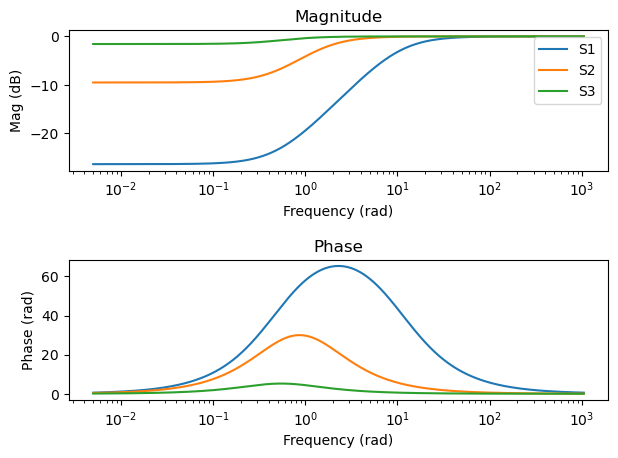

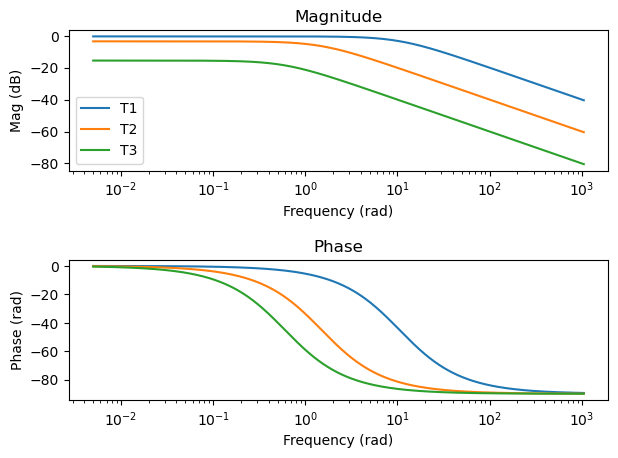

In [17]:
K1 = 10000
K2 = 1000
K3 = 100

den_cl1 = get_closed_loop_denominator(Car.num[0][0],Car.den[0][0], K1)
den_cl2 = get_closed_loop_denominator(Car.num[0][0],Car.den[0][0], K2)
den_cl3 = get_closed_loop_denominator(Car.num[0][0],Car.den[0][0], K3)

num_S = Car.den[0][0]
num_T1 = K1*Car.num[0][0]
num_T2 = K2*Car.num[0][0]
num_T3 = K3*Car.num[0][0]


N = 1000
omega = eu.enel441_get_reasonable_freq_range(num_S,den_cl1,N)
S_jw1 = eu.enel441_fourier_transform(num_S,den_cl1,omega)
S_jw2 = eu.enel441_fourier_transform(num_S,den_cl2,omega)
S_jw3 = eu.enel441_fourier_transform(num_S,den_cl3,omega)
T_jw1 = eu.enel441_fourier_transform(num_T1,den_cl1,omega)
T_jw2 = eu.enel441_fourier_transform(num_T2,den_cl2,omega)
T_jw3 = eu.enel441_fourier_transform(num_T3,den_cl3,omega)

fig, ax = eu.enel441_bode(S_jw1,omega,label='S1')
fig, ax = eu.enel441_bode(S_jw2,omega,label='S2', fig=fig, ax=ax,)
fig, ax = eu.enel441_bode(S_jw3,omega,label='S3', fig=fig, ax=ax,)
ax[0].legend()

fig, ax = eu.enel441_bode(T_jw1,omega, label='T1')
fig, ax = eu.enel441_bode(T_jw2,omega, fig=fig, ax=ax, label='T2')
fig, ax = eu.enel441_bode(T_jw3,omega, fig=fig, ax=ax, label='T3')
ax[0].legend()

# In Class Activity

Make a root-locus plot for the cruise-control system

Numerator: [0. 1.]
Denominator: [1000  500]


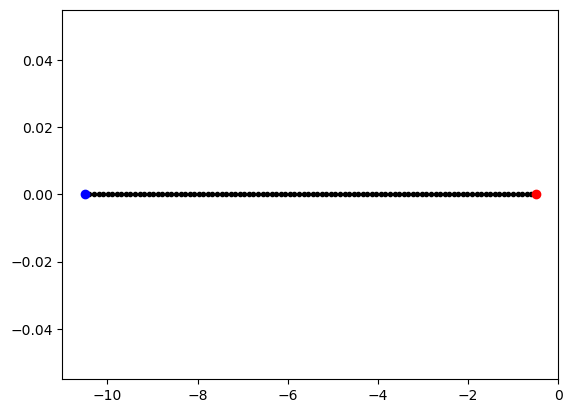

In [12]:
import numpy as np
import matplotlib.pyplot as plt


def enel441_root_locus(num,den,k_range):
    N = len(k_range)

    if len(num) == len(den):
        print('Nothing to do.')
        num_padded = num
        print(num)
        print(den)
    else:
        num_padded = np.concatenate((np.zeros(len(den)-len(num)), num))
        print('Numerator:', num_padded)
        print('Denominator:', den)

    closed_loop_poles = np.zeros((N,den.shape[0]-1),dtype=np.csingle)
    for ii in range(N):
        den_closed_loop = den + k_range[ii]*num_padded
        closed_loop_poles[ii,:] = np.roots(den_closed_loop)
    
    fig, ax = plt.subplots(1,1)
    ax.plot(np.real(closed_loop_poles),np.imag(closed_loop_poles), 'k.' )
    ax.plot(np.real(closed_loop_poles[0,:]),np.imag(closed_loop_poles[0,:]), 'ro' )
    ax.plot(np.real(closed_loop_poles[-1,:]),np.imag(closed_loop_poles[-1,:]), 'bo' )
    return fig, ax

k_range = np.linspace(0,10000,100)
fix,ax = enel441_root_locus(Car.num[0][0],Car.den[0][0],k_range) 
plt.show()

        




# What can we see from this plot?

- There is only a single pole for this closed loop system.
- We can place the pole anywhere on the real line.
- Recall: how does the pole location affect the step response of a first order system? 
- Is there a price to speeding up the system?

# In Class Activity

Look at the input $u$ to the controller. What happens to this input as we increase the responsiveness of the system?

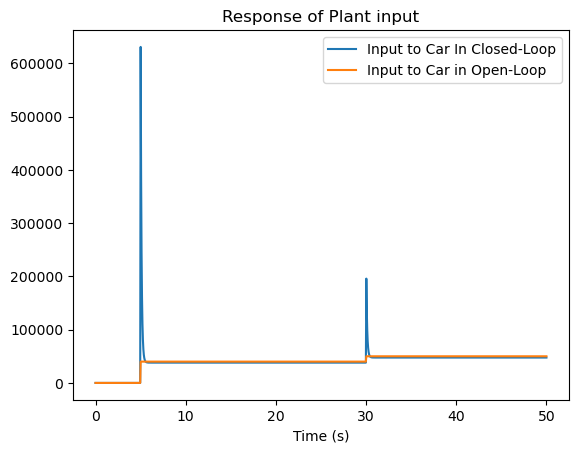

In [15]:
d = np.zeros(N)

Kp = ct.tf(10000,1)
fig,ax = plot_input_to_plant(Kp,Car,r,d,t)
ax.plot(t,r*k, label='Input to Car in Open-Loop')
ax.legend()



# Observation

Increasing the responsiveness of the system (i.e. faster rise time) requires a higher peak magnitude in the input to the plant. For a physical system, the input to the plant is applied by an actuator. This actuator may not be able to deliver the requested input. For example in the cruise-control example, pushing the engine has a limit as to how much force it can apply. 


    

# Look at another Example System - Active Suspension for a Car

![Car suspension](car_suspension.png "Car suspension")
source: https://auto.howstuffworks.com/car-suspension.htm


![Car suspension diagram](car-suspension-diagram.png "Car suspension diagram")


![Car suspension free body diagram](car-suspension-free-body-diagram.png "Car suspension free body diagram")

where,
- $F_u$ is the force applied by the active suspension
- $F_g$ is the force due to gravity
- $F_s$ is the force due to the spring
- $F_d$ is the force due to the damper
- $x_c$ is vertical position of car
- $x_g$ is vertical position of the ground

Force due to drag:
$$
\begin{align*}
F_d = k_d v_c 
\end{align*}
$$
where 
- $k_d$ is drag coefficient,
- $v_c$ is vertical speed of the car. 


# In Class Activity! 

Determine the transfer function from $F$ to $x$

Sum forces:
$$
\begin{align*}
\sum_k F_k &= ma \\
-F_s - F_d - F_g + F_u &= ma_c \\
-k(x_c-x_g) - b(\frac{dx_c}{dt}-\frac{dx_g}{dt}) - mg + F_u = m\frac{d^2x_c}{dt^2}
\end{align*}
$$
Take Laplace transform of both sides:
$$
\begin{align*}
-k(X_c(s) - X_g(s)) - b(sX_c(s) - sX_g(s)) - mg + F_u(s) = ms^2X_c(s) \\
 + X_g(s) (k + bs) - mg + F_u(s) = X_c(s) ( k + bs + ms^2) \\
X_c(s) = \frac{k+bs}{k + bs + ms^2}X_g(s) + \frac{1}{k + bs + ms^2}F_u(s) - \frac{mg}{k + bs + ms^2}
\end{align*}
$$
Let's take a pause here. For a linear system, if we double in the input, we will get double the output. Is our current expression for $X_c$ linear with respect to the inputs $F_u$ and $X_g$?

Let's double both inputs and determine the output. Let $\tilde{X}_c$ denote the output with doubled inputs:
$$
\begin{align*}
\tilde{X}_c(s) &= \frac{k+bs}{k + bs + ms^2}2 X_g(s) + \frac{1}{k + bs + ms^2}2 F_u(s) - \frac{mg}{k + bs + ms^2} \\
&= 2X_c(s) + \frac{mg}{k + bs + ms^2}
\end{align*}
$$

We did not get double the output (i.e. we don't have $\tilde{X}_c = 2X_c$)! The term due to gravity is getting in the way! 

Attempt #2. Write the equations around the equilibrium point (this will absorb the term due to gravity).

At equilibrium:
$$
\begin{align*}
x_c &= x_{eq}, \\
\frac{dx_c}{dt} &= 0, \\
\frac{d^2x_c}{dt^2} &= 0, \\
x_g &= 0, \\
\frac{dx_g}{dt} &= 0, \\
F_u &= 0
\end{align*}
$$
Substitute these values into the original expression, and solve for $x_{eq}$:
$$
\begin{align*}
-kx_{eq} - mg &= 0 \\
x_{eq} &= -\frac{mg}{k}
\end{align*}
$$
Now we can express $x_c$ is terms of a relative change from its equilibrium position:
$$
\begin{align*}
x_c = x_{eq} + x_{\Delta}
\end{align*}
$$

Note that the following equalities hold:
$$
\begin{align*}
\frac{d x_c}{dt} &= \frac{d x_{\Delta}}{dt} \\
\frac{d^2 x_c}{dt}^2 &= \frac{d^2 x_{\Delta}}{dt^2} 
\end{align*}
$$

Now substitute $x_c = x_{eq} + x_{\Delta}$ into the original differential equation:
$$
\begin{align*}
-k(x_{eq} + x_{\Delta}-x_g) - b(\frac{dx_{\Delta}}{dt}-\frac{dx_g}{dt}) - mg + F_u = m\frac{d^2x_{\Delta}}{dt^2}
\end{align*}
$$

Recall that $x_{eq} = -\frac{mg}{k}. Substitute this into the equation:
$$
\begin{align*}
-k(x_{\Delta}-x_g) - b(\frac{dx_{\Delta}}{dt}-\frac{dx_g}{dt}) + F_u = m\frac{d^2x_{\Delta}}{dt^2}
\end{align*}
$$

Take Laplace transform of both sides, and gather terms:
$$
\begin{align*}
(b s + k)X_g(s) + F(s) &= (ms^2 + bs + k) X_{\Delta}(s) \\
X_{\Delta}(s) &= \frac{(b s + k)}{(ms^2 + bs + k)}X_g(s) + \frac{1}{(ms^2 + bs + k)}F(s)
\end{align*}
$$

Numerator: [0. 0. 1.]
Denominator: [2.55 9.   7.5 ]


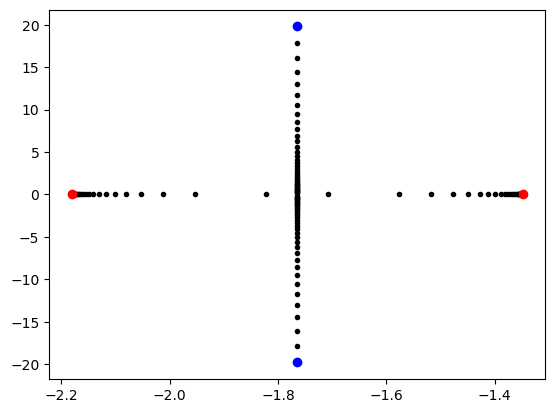

In [1]:
import control as ct
import numpy as np
import enel441_utilities as eu
import math
import scipy as sp
import matplotlib.pyplot as plt

b = 9
k = 7.5
m = 2.55

k_range = np.logspace(-6,3,100)
fig,ax = eu.enel441_root_locus(np.array([1]),np.array([m, b, k]),k_range) 
plt.show()


# What can we observe?

- System is stable for all $K$
- For small $K$, poles are real (near blue dot)
- For large $K$, poles are complex (near red dot)

# Suppose that we use a pneumatic actuator that is relatively slow.

Let the model for the actuator be $\frac{1}{s}$. What does the frequency response look like? 

So now the applied force is equal to $F(s) = F_c(s)/s$, where $F(s)$ is the output force of the actuator, and $F_c(s)$ is the commanded force. 

Plug this into our model:
$$
\begin{align*}
X_{\Delta}(s) &= \frac{(b s + k)}{(ms^2 + bs + k)}X_g(s) + \frac{1}{s(ms^2 + bs + k)}F_c(s)
\end{align*}
$$


# In Class Activity!

Look at Root Locus for the new model. What do you see?

Numerator: [0. 0. 0. 1.]
Denominator: [2.55 9.   7.5  0.  ]


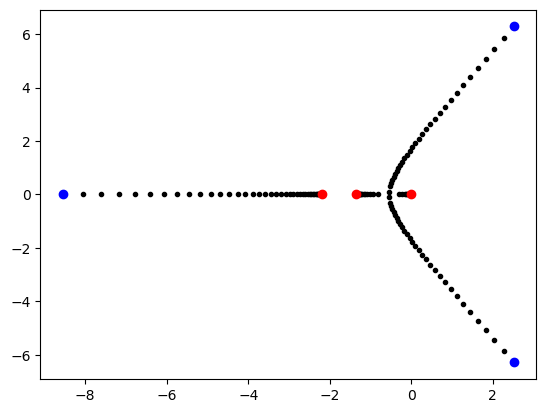

In [2]:
b = 9
k = 7.5
m = 2.55

k_range = np.logspace(-6,3,100)
fig,ax = eu.enel441_root_locus(np.array([1]),np.array([m, b, k, 0]),k_range) 
plt.show()

# What do we observe?

- Is the system stable for all $K$?

# Stability is a problem! 

Question: is there a way to tell if a system is stable using Bode plot? Or if it is close to being unstable?


In [30]:
N = 1000
num = np.array([1])
den1 = np.array([1, -1])
den2 = np.array([1, 1])
omega = eu.get_range(num,den1,N)
G_jw1 = eu.enel441_fourier_transform1(num,den1,omega)
G_jw2 = eu.enel441_fourier_transform1(num,den2,omega)
eu.enel441_bode(G_jw1,omega)
eu.enel441_bode(G_jw2,omega)

AttributeError: module 'enel441_utilities' has no attribute 'get_range'

Nyquist plot. How does stability show up now?

# Material for next lecture - back to feedback equation. 

So far have looked at increasing system performance, but what about the other advantages of control? (disturbance rejection and robustness)?

# Balancing Priorities

$$\varepsilon(s) =S(s)r(s) + T(s)n(s) - S(s)P(s)d(s)$$

![FrequencyDomainRepresentationDesiredSensitivity](sensitivityBode.png "Frequency Domain Representation of Desirable Sensitivity Function")

# That is great insight!
# However, how does this help us? Our ''tuning knob'' is the controller K...

In [ ]:
L = 1/s

S = 1/(1+L)
T = L/(1+L)
mag, phase, omega = bode([S, T], dB=True, plot=False)

fig, ax = plt.subplots(1,1, figsize = [10,5])
ax.semilogx(omega[0],[20*math.log10(x) for x in mag[0]], label='Sensitivity Function')
ax.semilogx(omega[1],[20*math.log10(x) for x in mag[1]], label='Complementary Sensitivity Function')
#ax.semilogx(omega[0],mag[0], label='Sensitivity Function')
#ax.semilogx(omega[1],mag[1], label='Complementary Sensitivity Function')
ax.set_xlabel('Frequency (rad/s)')
ax.set_ylabel('Magnitude (dB)')
ax.set_title('Bode Plot')
plt.legend(bbox_to_anchor=(1.05,1), borderaxespad=0)
plt.show()

# How does $K$ affect frequency response of $S$ and $T$?

$$
\begin{align}
S(s) &= \frac{1}{1+L(s)}  = \frac{1}{1+P(s)K(s)} \\
T(s) &= \frac{L(s)}{1+L(s)} = \frac{P(s)K(s)}{1+P(s)K(s)}  
\end{align}
$$

In [ ]:
L = 1/s

S = 1/(1+L)
T = L/(1+L)
mag, phase, omega = bode([S, T, L], dB=True, plot=False)



fig, ax = plt.subplots(1,1, figsize = [10,5])
ax.semilogx(omega[0],[20*math.log10(x) for x in mag[0]], label='Sensitivity Function')
ax.semilogx(omega[1],[20*math.log10(x) for x in mag[1]], label='Complementary Sensitivity Function')
ax.semilogx(omega[2],[20*math.log10(x) for x in mag[2]], label='Loop Transfer Function')
#ax.semilogx(omega[0],mag[0], label='Sensitivity Function')
#ax.semilogx(omega[1],mag[1], label='Complementary Sensitivity Function')
ax.set_xlabel('Frequency (rad/s)')
ax.set_ylabel('Magnitude (dB)')
ax.set_title('Bode Plot')
plt.legend(bbox_to_anchor=(1.05,1), borderaxespad=0)
#ax.grid(True)
plt.show()

![FrequencyDomainRepresentationDesiredLoop](desiredLoopTF.png "Frequency Domain Representation of Desirable Loop Function")

# Let's design $K$! (Idea 2)

![FrequencyDomainRepresentationDesiredLoop](desiredLoopTF.png "Frequency Domain Representation of Desirable Loop Function")

One possible loop transfer function that has our desired behaviour:

$$L(s) = \frac{1}{s}$$

(recall that this is the TF of an integrator)

But 
$$L(s) = K(s)P(s)$$
so can we solve for K?

Future topic: pole placement

In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import math


(0.999285366048076-0.037798904774643455j)
(1.4124976-0.040179603j)
(1.4099694-0.093541756j)
Using given axis.


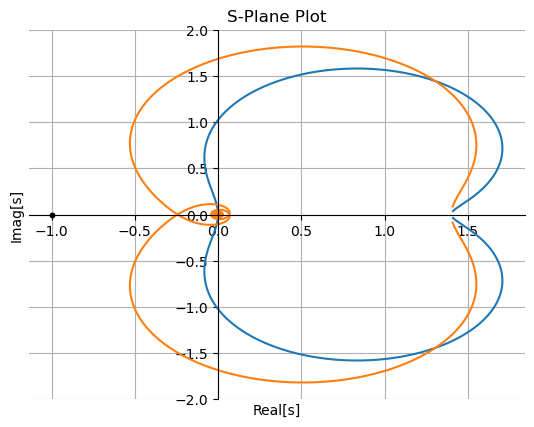

In [15]:
def my_fourier_transform(num,den,omega):
    N = omega.shape[0]
    G_jw = np.zeros(N,dtype=np.csingle)
       
    ii = 0
    for w in omega:
        jomega = 1j*w
        num_jw = 0
        jj = num.shape[0] - 1
        for nn in num:
            num_jw += nn*(jomega**jj)
            jj -= 1
        
        den_jw = 0
        jj = den.shape[0] - 1
        for dd in den:
            den_jw += dd*(jomega**jj)
            jj -= 1
        #print(den_jw)
        #print(num_jw)
        G_jw[ii] = num_jw/den_jw
        ii += 1
    return G_jw




def my_nyquist_plot(G_jw,omega,ax=[],fig=[]):
    if ax:
        print('Using given axis.')
    else:
        fig, ax = plt.subplots(1,1)
    
    ax.plot(np.real(G_jw), np.imag(G_jw))
    cur_color = ax.lines[-1].get_color()
    ax.plot(np.real(G_jw), -np.imag(G_jw),color=cur_color)

    ax.grid(True)
    ax.spines['left'].set_position('zero')
    # turn off the right spine/ticks
    ax.spines['right'].set_color('none')
    ax.yaxis.tick_left()
    # set the y-spine
    ax.spines['bottom'].set_position('zero')

    # turn off the top spine/ticks
    ax.spines['top'].set_color('none')
    ax.xaxis.tick_bottom()
    ax.set_title('S-Plane Plot')
    ax.set_xlabel('Real[s]')
    ax.set_ylabel('Imag[s]')

    ax.xaxis.set_label_coords(0.5,-0.01)
    ax.yaxis.set_label_coords(-0.01,0.5)

    ax.plot(-1,0,'k.')
    return fig, ax

num_sys = np.array([2, 7])
den_sys = np.array([1, 2, 5])

roots_den = np.roots(den_sys)
roots_num = np.roots(num_sys)
den_corner_freqs = np.abs(roots_den)
num_corner_freqs = np.abs(roots_num)

N = 1000
omega_min = np.min( [np.min(den_corner_freqs), np.min(num_corner_freqs)] )
omega_max = np.max( [np.max(den_corner_freqs), np.max(num_corner_freqs)] )
omega = np.logspace(np.log10(omega_min/10),np.log10(omega_max*100),num=N)

G_jw = my_fourier_transform(num_sys,den_sys,omega)

delay = np.exp(-complex(0,math.pi/4/5)*omega)
G_jw_rot = np.zeros(N,dtype=np.csingle)
for ii in range(N):
    G_jw_rot[ii] = G_jw[ii]*delay[ii]

print(delay[10])
print(G_jw[10])
print(G_jw_rot[10])

fig,ax = my_nyquist_plot(G_jw,omega)
fig,ax = my_nyquist_plot(G_jw_rot,omega,ax=ax,fig=fig)

In [12]:
complex(1,1)

(1+1j)

In [ ]:
make system unstable.

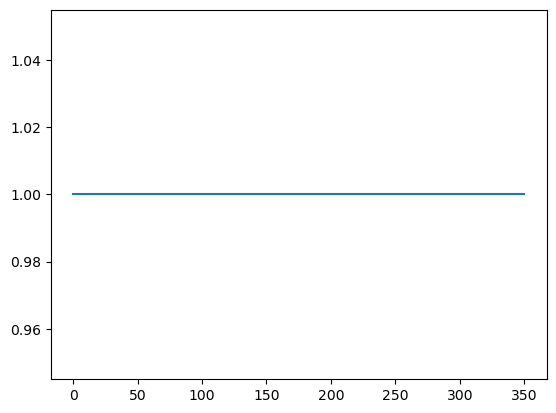

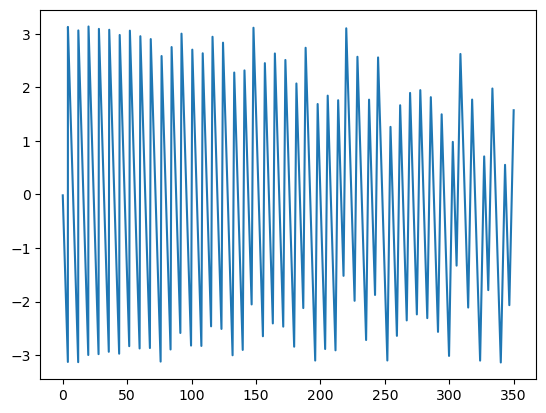

In [22]:

fig,ax = plt.subplots(1,1)
ax.plot(omega,np.abs(delay))
fig,ax = plt.subplots(1,1)
ax.plot(omega,np.angle(delay))
